In [1]:
import sys
sys.path.append("..")

from system_controller import SystemController
from utils import transform_angle_error, transform_02pi_to_negpospi
from neural_networks.dynamics_networks import TransferNN

import numpy as np
import time
import matplotlib.pyplot as plt
from time import perf_counter
from scipy.integrate import odeint
import os
from pathlib import Path

plt.style.use(["science", "grid"])

2023-04-26 19:33:04.006527: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import tensorflow as tf

In [3]:
def run_simulation(ds, controller, simulation_length, initial_state,
                   measurement_noise=False, save=False, save_fname=None):
    n_steps = int((1 / ds.dt) * simulation_length)

    # Create lists to store control sequence and state sequences for MPPI runs
    controls, states = np.empty((n_steps, ds.nu)), np.empty((n_steps, ds.nx))

    # Begin simulation
    current_state = initial_state
    start_time = perf_counter()

    for i in range(0, n_steps):
        if controller is None:
            current_state = ds.simulator(current_state, ds.null_action, measurement_noise=measurement_noise)
        else:
            action = controller.step(current_state)
            current_state = ds.simulator(current_state, action, measurement_noise=measurement_noise)
        
        current_state = ds.ensure_state(current_state)

        states[i] = current_state
        controls[i] = action
    
    end_time = perf_counter() 
    print("{} simulation elapsed time: {:.5f} s".format(str(ds), end_time - start_time))
    
    if save:
        np.savez(save_fname, states=states, controls=controls)
    
    time_points = time = np.linspace(0, simulation_length, n_steps)
    
    return states, controls, time_points

# Pendulum
Try MPPI controller with neural network dynamics model on an inverted pendulum.

### Controller Definition

In [4]:
# Get neural network model loaded
pend_model_path = Path(os.getcwd()).parent / "neural_networks" / "pendulum" / "models"
pend_availible_models = [x for x in pend_model_path.iterdir() if x.is_dir()]

for (i, model_name) in enumerate(pend_availible_models):
    print("[{}]  {}".format(i, model_name))

idx = int(input("Select which model number to load: "))
pend_nn_model = tf.keras.models.load_model(pend_availible_models[idx])

[0]  /Users/micahreich/Documents/16711-final-project/neural_networks/pendulum/models/inverted_pendulum_model_16nodes_18-04-2023 04:50:54
[1]  /Users/micahreich/Documents/16711-final-project/neural_networks/pendulum/models/pendulum_rollouts__24-04-2023 23:00:02
[2]  /Users/micahreich/Documents/16711-final-project/neural_networks/pendulum/models/inverted_pendulum_model_16nodes_20-04-2023 02:54:16
[3]  /Users/micahreich/Documents/16711-final-project/neural_networks/pendulum/models/pendulum_rollouts__23-04-2023 02:48:16
[4]  /Users/micahreich/Documents/16711-final-project/neural_networks/pendulum/models/pendulum_tanh_32_rollouts__26-04-2023 02:34:02
[5]  /Users/micahreich/Documents/16711-final-project/neural_networks/pendulum/models/pendulum_model_16nodes_rollouts
[6]  /Users/micahreich/Documents/16711-final-project/neural_networks/pendulum/models/pendulum_tanh_32_rollouts__26-04-2023 02:29:47
Select which model number to load: 4


2023-04-26 19:33:09.552690: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
from systems.dynamical_systems import Pendulum

pend_env = Pendulum(m=1, l=1, b=0.1, dt=1 / 10)

DESIRED_THETA = np.pi
DESIRED_OMEGA = 0.0

# Define the controller cost functions

def terminal_cost(x):
    theta, omega = x
    
    theta_error = np.cos(theta - DESIRED_THETA + np.pi) + 1
    omega_error = DESIRED_OMEGA - omega

    error = np.array([theta_error, omega_error])
    Q = np.diag([10, 1])

    return error.T @ Q @ error

def state_cost(x):
    theta, omega = x
        
    theta_error = transform_angle_error(DESIRED_THETA - theta)
        
    error = np.array([theta_error])
    Q = np.diag([1])

    return error.T @ Q @ error

pend_controller = SystemController(
    ds=pend_env,
    n_rollouts=100,
    horizon_length=10,
    exploration_cov=np.diag([0.5 ** 2]),
    exploration_lambda=1e-2,
    state_cost=state_cost, terminal_cost=terminal_cost,
    control_range={"min": pend_env.u_lo, "max": pend_env.u_hi},
    nn_model=pend_nn_model
).build()

## Neural Network vs. Ground Truth (Natural Dynamics)
Test the neural network dynamics model with the natural dynamics of the system before using it in the controller

In [6]:
# Test the neural network dynamics on the system's natural dynamics

INITIAL_STATE = np.array([np.radians(170), -6])

nn_current_state = INITIAL_STATE
truth_current_state = INITIAL_STATE

simulation_length = 5
n_steps = int((1 / pend_env.dt) * simulation_length)

# Simulate the pendulum
nn_states = np.empty((n_steps, pend_env.nx))
truth_states = np.empty((n_steps, pend_env.nx))

for i in range(n_steps):
    nn_states[i] = nn_current_state
    truth_states[i] = truth_current_state
    
    nn_input = np.hstack((nn_current_state, pend_env.null_action)).reshape(1, -1)
    nn_current_state = pend_controller._evolve_state(nn_input)[0]
    nn_current_state = pend_env.ensure_state(nn_current_state)
    
    truth_current_state = pend_env.simulator(truth_current_state, pend_env.null_action)
    truth_current_state = pend_env.ensure_state(truth_current_state)

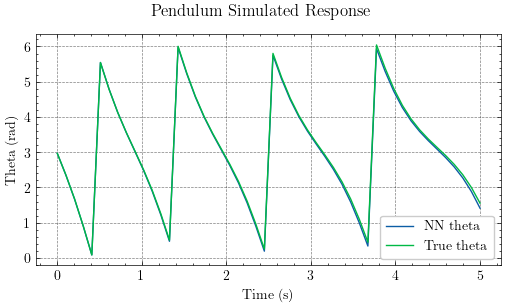

In [7]:
# Plot the simulated response

time = np.linspace(0, simulation_length, n_steps)

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
fig.suptitle("Pendulum Simulated Response")

ax.plot(time, nn_states[:, 0], label="NN theta")
ax.plot(time, truth_states[:, 0], label="True theta")
# ax.plot(time, truth_states[:, 1], label="True omega")


ax.set(xlabel="Time (s)", ylabel="Theta (rad)")
# ax.set_ylim([-np.pi-0.3, np.pi+0.3])
ax.legend()

fig.savefig("figs/nn_vs_true_theta_iv.png")

## Pendulum Swing Up Task
Test the MPPI controller on a swing-up task using the neural network dynamics model for rollouts.

In [8]:
def pend_initial_state_str(initial_state):
    theta, thetadot = initial_state
    return "pendulum_{:.3f}theta_{:.3f}thetadot_NN".format(theta, thetadot)

In [9]:
states, controls, time = run_simulation(ds=pend_env, controller=pend_controller, simulation_length=12,
                                        initial_state=np.array([np.radians(0), 0]))

pendulum simulation elapsed time: 3.28684 s


/var/folders/qn/w3_cwyl12lx4j5lszc52_bv40000gn/T/ipykernel_24038/2732484061.py:15: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


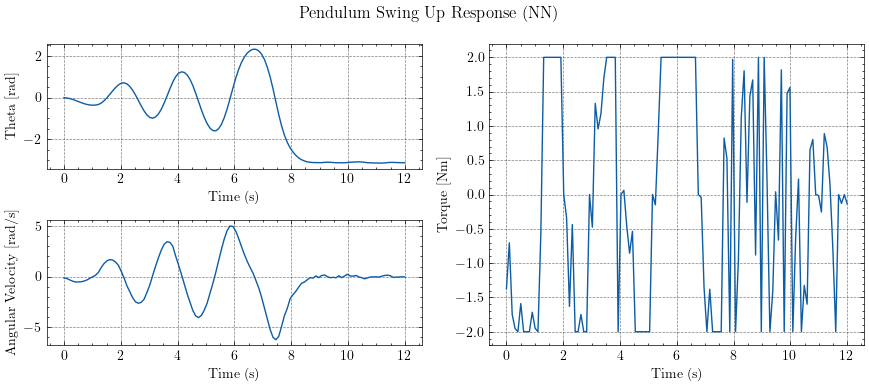

In [10]:
# Plot the results
fig, axd = plt.subplot_mosaic([['ul', 'r'], ['ll', 'r']], figsize=(9, 4), layout="constrained")

fig.suptitle("Pendulum Swing Up Response (NN)")

axd["ul"].plot(time, transform_02pi_to_negpospi(states[:, 0]), label="Theta")
axd["ul"].set(xlabel="Time (s)", ylabel="Theta [rad]")

axd["ll"].plot(time, states[:, 1], label="Angular Velocity")
axd["ll"].set(xlabel="Time (s)", ylabel="Angular Velocity [rad/s]")

axd["r"].plot(time, controls[:, 0])
axd["r"].set(xlabel="Time (s)", ylabel="Torque [Nm]")

plt.tight_layout()
fig.savefig("figs/pendulum_swingup_nn.png")

## Online Learning Example
Let's change the inertial properties of the inverted pendulum system and continuously train the dynamics model on newly collected data.

In [81]:
ONLINE_LR = 1e-2

pend_env = Pendulum(m=1, l=1, b=0.1, dt=1 / 10)
pend_base_model = tf.keras.models.load_model(pend_availible_models[idx])
pend_transfer_model = TransferNN(base_model=pend_base_model, lr=ONLINE_LR)

def nn_evolve_state(nn_input):
    states, controls = nn_input[:, :pend_env.nx], nn_input[:, pend_env.nx:]
    x_ddots = pend_transfer_model.transfer_model(nn_input)

    x_dots = states[:, 1::2]

    next_states = states
    next_states[:, ::2] += x_dots * pend_env.dt + 1 / 2 * x_ddots * (pend_env.dt ** 2)
    next_states[:, 1::2] += x_ddots * pend_env.dt

    return next_states

pend_controller = SystemController(
    ds=pend_env,
    n_rollouts=100,
    horizon_length=10,
    exploration_cov=np.diag([0.5 ** 2]),
    exploration_lambda=1e-2,
    state_cost=state_cost, terminal_cost=terminal_cost,
    control_range={"min": pend_env.u_lo, "max": pend_env.u_hi},
    nn_model=pend_nn_model
).build()

Model: "transfer_learning_dynamics_nn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_input (InputL  [(None, None)]           0         
 ayer)                                                           
                                                                 
 normalization (Normalizatio  (None, 3)                7         
 n)                                                              
                                                                 
 dense (Dense)               (None, 32)                128       
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 transfer_layer (Dense)      (None, 16)                528       
                                                                 
 out_layer (Dense)           (None, 1

In [82]:
# Set up online learning parameters
RETRAIN_ITERS = 2

def init_new_data():
    new_examples = np.empty((RETRAIN_ITERS, pend_env.nx + pend_env.nu))
    new_labels = np.empty((RETRAIN_ITERS, pend_env.nx // 2))
    
    return new_examples, new_labels

def label_from_states(initial_state, next_state):
    acceleration = (next_state[1::2] - initial_state[1::2]) / pend_env.dt
    return acceleration

x_data, y_data = init_new_data()

# Test the neural network dynamics on the system's natural dynamics

INITIAL_STATE = np.array([np.radians(45), 0])

nn_current_state = INITIAL_STATE
truth_current_state = INITIAL_STATE

simulation_length = 30
n_steps = int((1 / pend_env.dt) * simulation_length)

# Simulate the pendulum
nn_states = np.empty((n_steps, pend_env.nx))
truth_states = np.empty((n_steps, pend_env.nx))

start_time = perf_counter()

for i in range(n_steps):
    truth_prev_state = pend_env.ensure_state(truth_current_state)
    
    nn_states[i] = nn_current_state
    truth_states[i] = truth_current_state
    
    nn_input = np.hstack((nn_current_state, pend_env.null_action)).reshape(1, -1)
    nn_current_state = nn_evolve_state(nn_input)[0]
    nn_current_state = pend_env.ensure_state(nn_current_state)
    
    truth_current_state = pend_env.simulator(truth_current_state, pend_env.null_action)
    truth_current_state = pend_env.ensure_state(truth_current_state)
    
    x_data[i % RETRAIN_ITERS] = nn_input
    y_data[i % RETRAIN_ITERS] = label_from_states(truth_prev_state, truth_current_state)
    
    # Retrain if current time step is a retrain step
    if i % RETRAIN_ITERS == 0 and i > 0:
        pend_transfer_model.train(x_data, y_data, n_epochs=5)
        x_data, y_data = init_new_data()
        
end_time = perf_counter()
print("time: {:.2f}".format(end_time - start_time))

time: 5.77


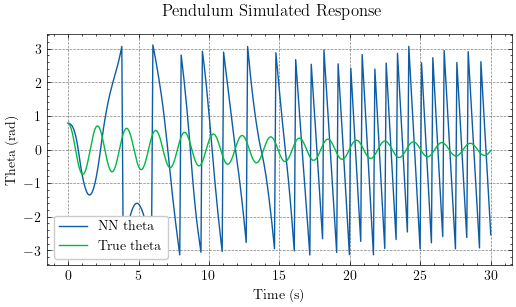

In [83]:
# Plot the simulated response

time = np.linspace(0, simulation_length, n_steps)

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
fig.suptitle("Pendulum Simulated Response")

ax.plot(time, transform_02pi_to_negpospi(nn_states[:, 0]), label="NN theta")
ax.plot(time, transform_02pi_to_negpospi(truth_states[:, 0]), label="True theta")

ax.set(xlabel="Time (s)", ylabel="Theta (rad)")
ax.legend()

fig.savefig("figs/nn_vs_true_theta_iv.png")

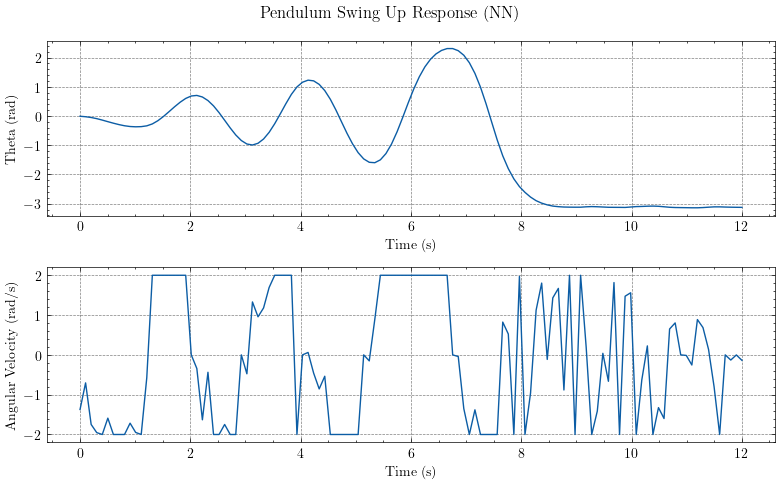

In [28]:
# Plot the results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 5))

fig.suptitle("Pendulum Swing Up Response (NN)")

time = np.linspace(0, simulation_length, n_steps)

ax1.plot(time, transform_02pi_to_negpospi(states[:, 0]), label="Theta")
ax1.set(xlabel="Time (s)", ylabel="Theta (rad)")

ax2.plot(time, controls[:, 0], label="Angular Velocity")
ax2.set(xlabel="Time (s)", ylabel="Angular Velocity (rad/s)")

plt.tight_layout()

fig.savefig("figs/pendulum_swingup_online.png")

# Cart-Pole
Try MPPI controller with a cart-pole system

### Controller Definition

In [ ]:
# Get neural network model loaded
cartpole_model_path = Path(os.getcwd()).parent / "neural_networks" / "cartpole" / "models"
cartpole_availible_models = [x for x in cartpole_model_path.iterdir() if x.is_dir()]

for (i, model_name) in enumerate(cartpole_availible_models):
    print("[{}]  {}".format(i, model_name))

idx = int(input("Select which model number to load: "))
cartpole_nn_model = tf.keras.models.load_model(cartpole_availible_models[idx])

In [ ]:
from systems.dynamical_systems import CartPole

cartpole_env = CartPole(m_pole=1, m_cart=1, l=1, dt=1 / 10)

DESIRED_THETA = np.pi
DESIRED_CARTVEL = 0.0
DESIRED_CARTPOS = 0.0

# Define the controller cost functions

def terminal_cost(x):
    pos, posdot, theta, thetadot = x

    theta_error = np.cos(theta - DESIRED_THETA + np.pi) + 1
    vel_error = DESIRED_CARTVEL - posdot
    pos_error = DESIRED_CARTPOS - pos

    error = np.array([theta_error, vel_error, pos_error])
    Q = np.diag([500, 10, 10])

    return error.T @ Q @ error

def state_cost(x):
    return terminal_cost(x)

cartpole_controller = SystemController(
    ds=cartpole_env,
    n_rollouts=150,
    horizon_length=10,
    exploration_cov=np.diag([2 ** 2]),
    exploration_lambda=2e-3,
    terminal_cost=terminal_cost,
    state_cost=state_cost,
    control_range={"min": cartpole_env.u_lo, "max": cartpole_env.u_hi},
    nn_model=cartpole_nn_model
).build()

## Neural Network vs. Ground Truth (Natural Dynamics)
Test the neural network dynamics model with the natural dynamics of the system before using it in the controller

In [ ]:
# Test the neural network dynamics on the system's natural dynamics

INITIAL_STATE = np.array([0.0, 0.0, np.radians(80), 0])

nn_current_state = INITIAL_STATE
truth_current_state = INITIAL_STATE

simulation_length = 5
n_steps = int((1 / cartpole_env.dt) * simulation_length)

# Simulate the pendulum
nn_states = np.empty((n_steps, cartpole_env.nx))
truth_states = np.empty((n_steps, cartpole_env.nx))

for i in range(n_steps):
    nn_states[i] = nn_current_state
    truth_states[i] = truth_current_state
    
    nn_input = np.hstack((nn_current_state, cartpole_env.null_action)).reshape(1, -1)
    nn_current_state = cartpole_controller._evolve_state(nn_input)[0]
    nn_current_state = cartpole_env.ensure_state(nn_current_state)
    
    truth_current_state = cartpole_env.simulator(truth_current_state, cartpole_env.null_action)
    truth_current_state = cartpole_env.ensure_state(truth_current_state)

In [ ]:
# Plot the results
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(8, 8.5))

# fig.suptitle("Cart-Pole Response")
time = np.linspace(0, simulation_length, n_steps)

ax1.plot(time, nn_states[:, 0], label="NN")
ax1.plot(time, truth_states[:, 0], label="Truth")
ax1.set(ylabel="Position (m)", title="Cart-Pole Simulated Response")
ax1.legend(loc="lower right")

ax2.plot(time, nn_states[:, 1], label="NN")
ax2.plot(time, truth_states[:, 1], label="Truth")
ax2.set(ylabel="Velocity (m/s)")
ax2.legend(loc="lower right")

ax3.plot(time, nn_states[:, 2], label="NN")
ax3.plot(time, truth_states[:, 2], label="Truth")
ax3.set(ylabel="Angle (rad)")
ax3.legend(loc="lower right")

ax4.plot(time, nn_states[:, 3], label="NN")
ax4.plot(time, truth_states[:, 3], label="Truth")
ax4.set(ylabel="Anglualr Velocity (rad/s)")
ax4.legend(loc="lower right")

plt.xlabel("Time (s)")
plt.tight_layout()

fig.savefig("figs/cartpole_vs_gt_from80deg.png")

## Cart Pole Swing Up Task
Test the MPPI controller on a cartpole swing-up task using the neural network dynamics model for rollouts.

In [ ]:
def cartpole_initial_state_str(initial_state):
    p, pdot, theta, thetadot = initial_state
    return "cartpole_{:.3f}theta_{:.3f}vel_NN".format(theta, pdot)

In [ ]:
states, controls, time = run_simulation(ds=cartpole_env, controller=cartpole_controller, simulation_length=10,
                                 initial_state=np.array([0, 0, 0, 0]))

In [ ]:
# Plot the results
fig, axd = plt.subplot_mosaic([['ul', 'ur'],
                               ['ll', 'lr']], figsize=(9, 4), layout="constrained")

fig.suptitle("Cart-Pole Swing Up Response (NN)")

axd["ul"].plot(time, states[:, 0])
axd["ul"].set(xlabel="Time (s)", ylabel="Position [m]")

axd["ll"].plot(time, states[:, 1])
axd["ll"].set(xlabel="Time (s)", ylabel="Velocity [m/s]")

axd["ur"].plot(time, states[:, 2])
axd["ur"].set(xlabel="Time (s)", ylabel="Angle [m]")

axd["lr"].plot(time, states[:, 3])
axd["lr"].set(xlabel="Time (s)", ylabel="Angular Velocity [m/s]")

plt.tight_layout()
fig.savefig("figs/cartpole_swingup_nn.png")

## Cart Pole Swing Up Task with Obstacles
Test the MPPI controller on a cartpole swing-up task with an obstacle that ranges from [-2, 2] on the x-axis

In [ ]:
DESIRED_THETA = np.pi
DESIRED_CARTVEL = 0.0
DESIRED_CARTPOS = 2.0

# Define the controller cost functions

def terminal_cost(x):
    pos, posdot, theta, thetadot = x

    theta_error = transform_angle_error(DESIRED_THETA - theta)
    vel_error = DESIRED_CARTVEL - posdot
    pos_error = DESIRED_CARTPOS - pos

    error = np.array([theta_error, vel_error, pos_error])
    Q = np.diag([40, 1, 4])
    cost = error.T @ Q @ error
    
    if -2 <= pos <= 2:
        cost += 1e3

    return cost

def state_cost(x):
    return terminal_cost(x)

cartpole_obstacle_controller = SystemController(
    ds=cartpole_env,
    n_rollouts=150,
    horizon_length=10,
    exploration_cov=np.diag([2 ** 2]),
    exploration_lambda=1e-7,
    terminal_cost=terminal_cost,
    state_cost=state_cost,
    control_range={"min": cartpole_env.u_lo, "max": cartpole_env.u_hi},
    nn_model=cartpole_nn_model
).build()

In [ ]:
states, controls, time = run_simulation(ds=cartpole_env, controller=cartpole_obstacle_controller,
                                        simulation_length=6, initial_state=np.array([0, 0, 0, 0]))

In [ ]:
# Plot the results
fig, axd = plt.subplot_mosaic([['ul', 'ur'],
                               ['ll', 'lr']], figsize=(9, 4), layout="constrained")

fig.suptitle("Cart-Pole Swing Up Response (NN)")

axd["ul"].plot(time, states[:, 0])
axd["ul"].set(xlabel="Time (s)", ylabel="Position [m]")

axd["ll"].plot(time, states[:, 1])
axd["ll"].set(xlabel="Time (s)", ylabel="Velocity [m/s]")

axd["ur"].plot(time, states[:, 2])
axd["ur"].set(xlabel="Time (s)", ylabel="Angle [m]")

axd["lr"].plot(time, states[:, 3])
axd["lr"].set(xlabel="Time (s)", ylabel="Angular Velocity [m/s]")

plt.tight_layout()
fig.savefig("figs/cartpole_swingup_nn.png")